<a href="https://colab.research.google.com/github/Yospy/Emotions-Detection-using-RNN-and-LSTM/blob/main/Emotion_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
from numpy import *
import matplotlib.pyplot as plt
import tensorflow as tf

In [5]:
def get_dataset_as_df(filepath):
  data = []
  with open(filepath,'r') as file:
    for sentence in file:
      data.append(sentence[:-1].split(';'))
    data = pd.DataFrame(data, columns=['Text','Sentiment'])
    file.close()
  return data
  

In [6]:
train_path = '/content/train.txt'
train = get_dataset_as_df(train_path)
train.head()

,Text,Sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [7]:
train.describe()

,Text,Sentiment
count,16000,16000
unique,15969,6
top,i feel on the verge of tears from weariness i ...,joy
freq,2,5362


In [8]:
train.Sentiment.unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [11]:
train.groupby('Sentiment').count()

,Text
Sentiment,
anger,2159
fear,1937
joy,5362
love,1304
sadness,4666
surprise,572


In [12]:
from sklearn.preprocessing import LabelEncoder
normal = LabelEncoder()
train.Sentiment = normal.fit_transform(train.Sentiment)

In [13]:
train.head()

,Text,Sentiment
0,i didnt feel humiliated,4
1,i can go from feeling so hopeless to so damned...,4
2,im grabbing a minute to post i feel greedy wrong,0
3,i am ever feeling nostalgic about the fireplac...,3
4,i am feeling grouchy,0


In [14]:
normal.classes_

array(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
      dtype=object)

Text(0.5, 1.0, 'Distribution of Sentiments')

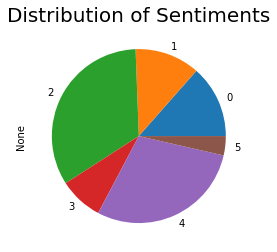

In [21]:
train.groupby('Sentiment').size().plot(kind='pie')
plt.title("Distribution of Sentiments",fontsize=20)

In [23]:
max_len_text = 0
for text in train.Text:
  max_len_text = max(max_len_text, len(text.split()))
print("Maximum number of words in sample dataset:", max_len_text)

Maximum number of words in sample dataset: 66


In [29]:
vocabulary_training = 40000
length_of_sentence = 66

In [63]:
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=vocabulary_training, output_sequence_length=length_of_sentence,
                                                    standardize='lower_and_strip_punctuation',
                                                    output_mode = 'int', pad_to_max_tokens=True)

In [64]:
text_vectorizer.adapt(train.Text)

In [65]:
text_vectorizer(train.Text[5])

<tf.Tensor: shape=(66,), dtype=int64, numpy=
array([ 73,  48,   9,   7,  56, 528, 320, 328, 158, 161,   8,  20,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0])>

In [66]:
text_embedding = tf.keras.layers.Embedding(mask_zero=True, input_dim=vocabulary_training, output_dim=300)

In [67]:
text_embedding(text_vectorizer(train.Text[5]))

<tf.Tensor: shape=(66, 300), dtype=float32, numpy=
array([[ 0.00299617, -0.02896177, -0.03906926, ..., -0.01566765,
         0.02937354, -0.04486177],
       [-0.02827051,  0.00203846, -0.02702584, ...,  0.01827458,
         0.0004483 , -0.02974325],
       [ 0.02231162,  0.04365439, -0.03838094, ...,  0.00163045,
         0.0270842 ,  0.0419857 ],
       ...,
       [-0.00884789,  0.0254295 , -0.00871545, ...,  0.04867681,
        -0.02607377,  0.00513626],
       [-0.00884789,  0.0254295 , -0.00871545, ...,  0.04867681,
        -0.02607377,  0.00513626],
       [-0.00884789,  0.0254295 , -0.00871545, ...,  0.04867681,
        -0.02607377,  0.00513626]], dtype=float32)>

In [68]:
X = train.Text
y = train.Sentiment

In [69]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=50)

In [70]:
training_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [71]:
train_data = training_data.batch(32).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [72]:
input_layer = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
vectorizer_layer = text_vectorizer(input_layer)
embedding_layer = text_embedding(vectorizer_layer)
lstm_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(48, return_sequences=True))(embedding_layer)
lstmm_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(lstm_layer)
bidi_layer = tf.keras.layers.LSTM(64)(lstmm_layer)
normalization_layer = tf.keras.layers.BatchNormalization()(bidi_layer)
dense_layer = tf.keras.layers.Dense(500, activation='relu')(normalization_layer)
dropout_layer = tf.keras.layers.Dropout(0.3)(dense_layer)
output_layer = tf.keras.layers.Dense(6, activation='sigmoid')(dropout_layer)
base_model = tf.keras.Model(input_layer, output_layer)

In [73]:
base_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_8 (TextV  (None, 66)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 66, 300)           12000000  
                                                                 
 bidirectional_6 (Bidirectio  (None, 66, 96)           134016    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 66, 256)          230400    
 nal)                                                            
                                                           

In [78]:
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.001,
    decay_steps = 500,
    decay_rate = 0.8
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
optimizer_ = tf.keras.optimizers.Adam(learning_rate = lr_scheduler)
base_model.compile(optimizer = optimizer_, metrics = ['acc'], loss = 'sparse_categorical_crossentropy') 

In [81]:
base_model.fit(X_train,y_train,epochs=5,callbacks=[callback])

Epoch 1/5
400/400 [==============================] - ETA: 0s - loss: 0.0753 - acc: 0.9746

400/400 [==============================] - 109s 273ms/step - loss: 0.0753 - acc: 0.9746
Epoch 2/5
400/400 [==============================] - ETA: 0s - loss: 0.0454 - acc: 0.9865

400/400 [==============================] - 109s 273ms/step - loss: 0.0454 - acc: 0.9865
Epoch 3/5
400/400 [==============================] - ETA: 0s - loss: 0.0287 - acc: 0.9913

400/400 [==============================] - 108s 270ms/step - loss: 0.0287 - acc: 0.9913
Epoch 4/5
400/400 [==============================] - ETA: 0s - loss: 0.0216 - acc: 0.9934

400/400 [==============================] - 108s 270ms/step - loss: 0.0216 - acc: 0.9934
Epoch 5/5
400/400 [==============================] - ETA: 0s - loss: 0.0163 - acc: 0.9948

400/400 [==============================] - 108s 270ms/step - loss: 0.0163 - acc: 0.9948


In [82]:
test = '/content/test.txt'
test = get_dataset_as_df(test)
test.head()

,Text,Sentiment
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [101]:
y_predict = base_model.predict(test.Sentiment)